<a href="https://colab.research.google.com/github/desirajusantosh/DS/blob/master/bear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.7MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.1MB 40.1MB/s 
     |████████████████████████████████| 194kB 60.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 40kB 6.4MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 2.6MB 44.9MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'a5b41c878c5e452999209a29b1ae6f1c')

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [7]:
import os
os.mkdir("images")
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

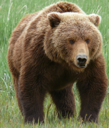

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [11]:
fns = get_image_files(path)
fns

(#446) [Path('bears/teddy/00000007.jpg'),Path('bears/teddy/00000092.jpg'),Path('bears/teddy/00000054.jpg'),Path('bears/teddy/00000082.jpg'),Path('bears/teddy/00000071.jpg'),Path('bears/teddy/00000045.jpg'),Path('bears/teddy/00000004.jpg'),Path('bears/teddy/00000134.jpg'),Path('bears/teddy/00000061.jpg'),Path('bears/teddy/00000138.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#8) [Path('bears/teddy/00000044.jpg'),Path('bears/teddy/00000036.jpg'),Path('bears/teddy/00000113.jpg'),Path('bears/teddy/00000140.jpg'),Path('bears/black/00000029.jpg'),Path('bears/black/00000114.jpg'),Path('bears/black/00000025.jpg'),Path('bears/grizzly/00000019.jpg')]

In [13]:
failed.map(Path.unlink);

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = bears.dataloaders(path)

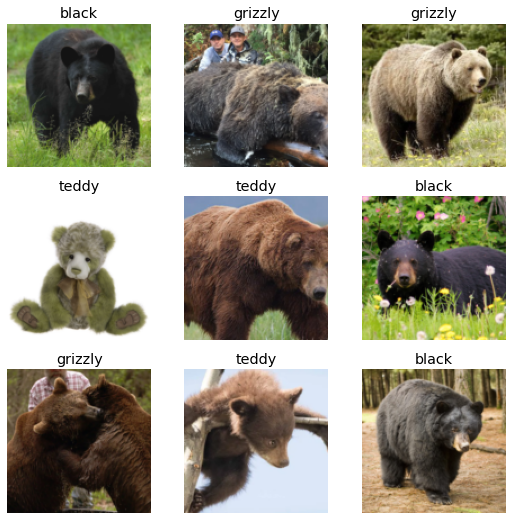

In [16]:
dls.valid.show_batch()

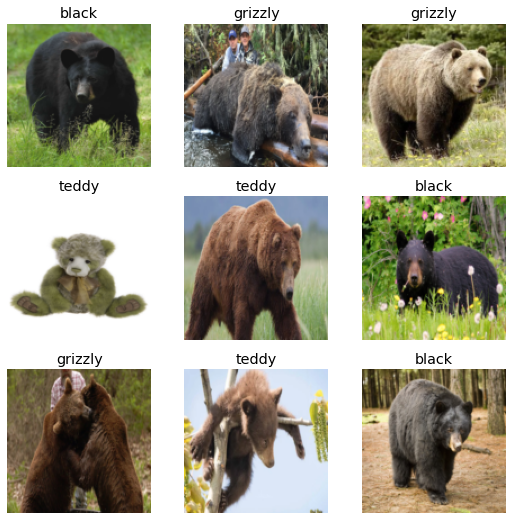

In [17]:
bears = bears.new(item_tfms=Resize(128,ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch()

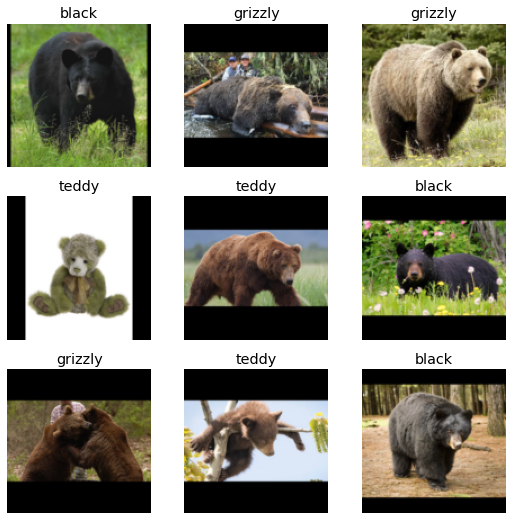

In [18]:
bears = bears.new(item_tfms=Resize(128,ResizeMethod.Pad,pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch()

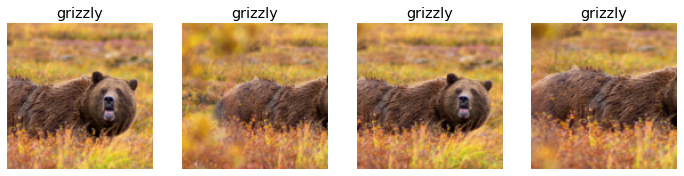

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

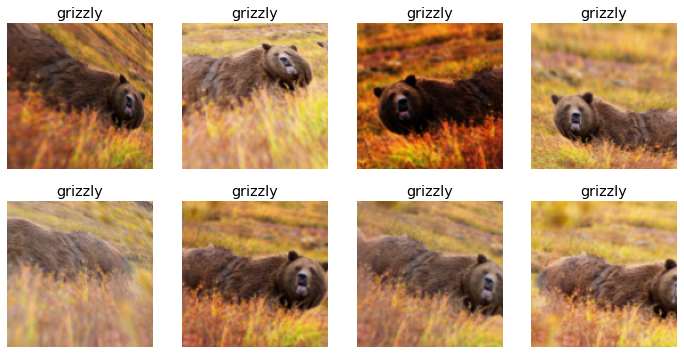

In [20]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

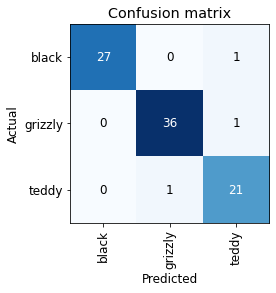

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

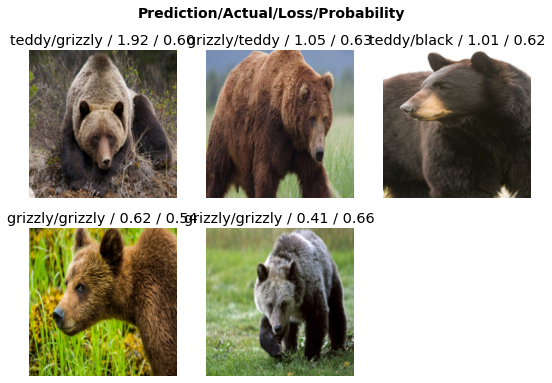

In [24]:
interp.plot_top_losses(5)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([0.0011, 0.9971, 0.0018]))

In [30]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [32]:
btn_upload = widgets.FileUpload()
btn_upload 

FileUpload(value={}, description='Upload')

In [33]:
img = PILImage.create(btn_upload.data[-1])


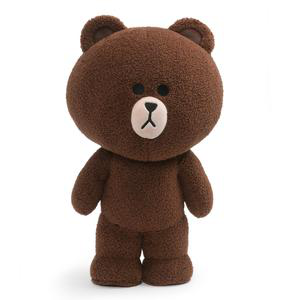

In [34]:
img

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9961')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [42]:
!pip install voila
!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 1.9MB 2.7MB/s 
     |████████████████████████████████| 552kB 19.4MB/s 
     |████████████████████████████████| 112kB 23.4MB/s 
     |████████████████████████████████| 204kB 19.8MB/s 
ERROR: nbdev 1.1.5 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
